In [1]:
import torch as th
from time import time
from params import default_params, set_tsp_params

# ------------------------- SET DEFAULT DEVICE -------------------
params = default_params()
params['device'] = "cuda" if th.cuda.is_available() else "cpu"
print("Device in use: ", params['device'])
th.device(params['device'])
# ----------------------------------------------------------------

# ------------------------- ENVIRONMENTS ---------------------------
from environments.environment_tsp import EnviornmentTSP
# ----------------------------------------------------------------

# ------------------------- NETWORKS -------------------------------
from networks.basic_network import BasicNetwork
from networks.more_basic_net import MoreBasicNetwork
from networks.embedder_network import EmbedderNetwork
from networks.transformer import Transformer
from networks.new_transformer import NewTransformer
# ----------------------------------------------------------------

# ------------------------- EXPERIMENTS ----------------------------
from experiments.actor_critic_experiment import ActorCriticExperiment
# ----------------------------------------------------------------

# ------------------------- CONTROLLERS ----------------------
from controllers.ac_controller import ActorCriticController
from controllers.epsilon_greedy_controller import EpsilonGreedyController
# ------------------------------------------------------------------

# ------------------------- LEARNERS --------------------------------
from learners.ppo_learner import PPOLearner
from learners.actor_critic_learner import ActorCriticLearner
# ------------------------------------------------------------------

from generators.tsp_generator import TSPGenerator
from solvers.gurobi_tsp import solve_tsp

Device in use:  cuda


In [2]:
max_nodes_per_graph = 10
rollouts_per_batch = 50
pct_epsilon_anneal_time = 0.8
max_episodes = 1500
pct_entropy_anneal_time = 0.9

# Debugging outputs and plotting during training
# params['plot_frequency'] = 10
# params['plot_train_samples'] = True
# params['debug_messages'] = False
# params['print_dots'] = False

# Environment parameters
params['env'] = 'tsp'
params['node_dimension'] = 2
params['max_nodes_per_graph'] = max_nodes_per_graph
params['max_episode_length'] = max_nodes_per_graph + 1
params['diff_sizes'] = True
params['diff_cities'] = True
params['use_training_set'] = False
params['training_sizes'] = [5, 6, 7, 8, 9, max_nodes_per_graph]
params['num_train_instance_per_size'] = 10

# Runner parameters
params['max_episodes'] = max_episodes
params['max_steps'] = params['max_episodes'] * params['max_episode_length'] * rollouts_per_batch
params['multi_runner'] = True               
params['parallel_environments'] = 4

# Exploration parameters
params['epsilon_anneal_time'] =  pct_epsilon_anneal_time * params['max_steps']
params['epsilon_finish'] = 1E-5
params['epsilon_start'] = 1.0
params['epsilon_decay'] = "linear"
params['entropy_regularization'] = True
# params['entropy_weight'] = 0.1
params['use_epsilon_greedy'] = False
params['decay_entropy'] = True
params['entropy_weight_start'] = 1.0
params['entropy_weight_end'] = 0.001
params['entropy_anneal_time'] = pct_entropy_anneal_time * params['max_episodes']


# Optimization parameters
params['lr'] = 5E-4
params['gamma'] = 0.99
params['batch_size'] = params['max_episode_length'] * rollouts_per_batch
params['grad_norm_clip'] = 1

# Actor-critic parameters
params['value_loss_param'] = 0.1
params['advantage_bias'] = True
params['advantage_bootstrap'] = True
params['offpolicy_iterations'] = 10
params['value_targets'] = 'td'

# PPO parameters
params['ppo_clipping'] = True
params['ppo_clip_eps'] = 0.1

# Network parameters
params['embedding_dimension'] = 4              
params['encoder_layers'] = 6                
params['model_dimension'] = 512      
params['dimension_k'] = 64
params['dimension_v'] = 64             
params['num_heads'] = 4               
params['num_layers'] = 3 
params['normalization'] = 'batch'
params['feed_forward_hidden'] = 512      
params['embed_dim'] = 4

# Device
# params['device'] = 'cpu'
params['use_tqdm'] = False
params['final_plot'] = False
params['wandb'] = False

print("Epsilon anneal time: ", params['epsilon_anneal_time'])
print("Total transitions: ", params['max_steps'])

Epsilon anneal time:  220000.0
Total transitions:  275000


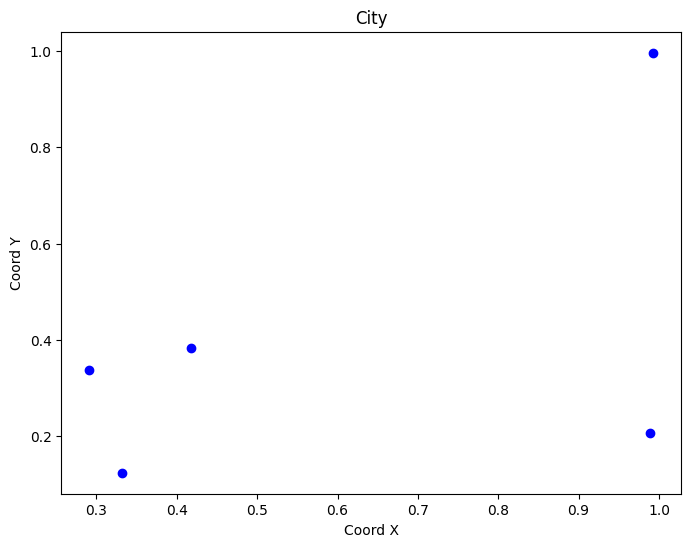

Restricted license - for non-production use only - expires 2025-11-24
Distance:  2.6435993909835815


In [3]:
nodes_per_graph = 5
instance = 0
cities = th.load(f"training/tsp/size_{nodes_per_graph}/instance_{instance}.pt")
#cities = cities.to(params['device'])
tsp_generator = TSPGenerator()
tsp_generator.plot_instance(cities)
permutation, distance = solve_tsp(cities)
print("Distance: ", distance)

In [4]:
cum_dist = 0
for i in range(10):
    avg_cities = th.load(f"training/tsp/size_{nodes_per_graph}/instance_{i}.pt")
    permutation, distance = solve_tsp(avg_cities)
    cum_dist += distance
print(f"Average distance: {cum_dist/10}")

Average distance: 2.0583256583660843


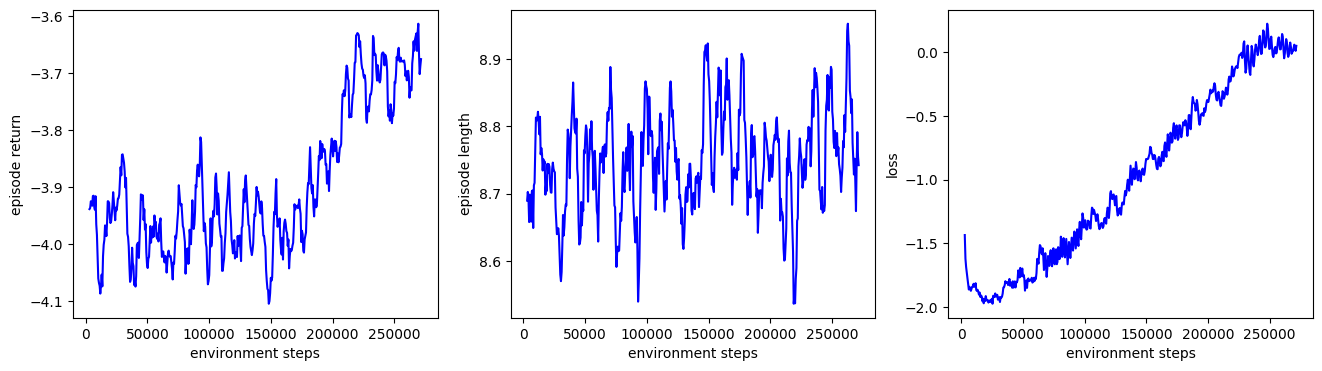

Total spended time in experiment:  1173.3558135032654


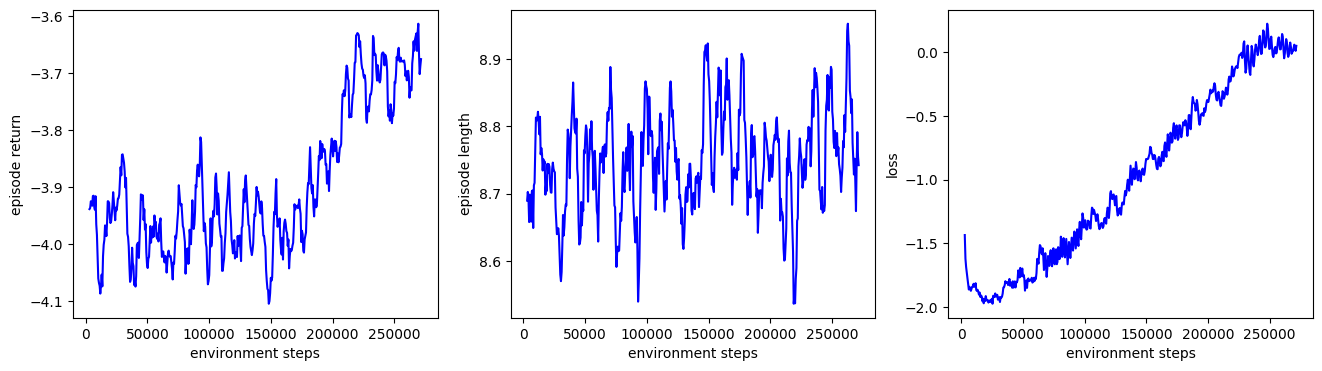

In [5]:
model = NewTransformer(params=params)
env = EnviornmentTSP(params=params)

# Run experiment
experiment = ActorCriticExperiment(params, model, env, PPOLearner(model=model, params=params))
start = time()
experiment.run()
end = time()
total_time = end - start
print("Total spended time in experiment: ", total_time)

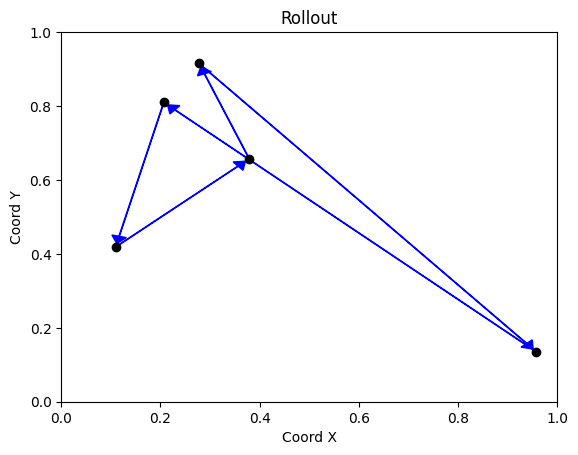

Tour distance: 3.0855371952056885


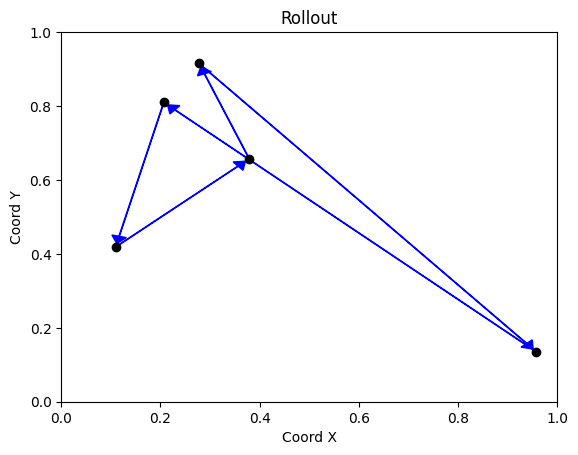

In [6]:
experiment.plot_rollout()

In [7]:
avg_gap = experiment.compare_vs_baseline_greedy_rollout(num_episodes=100)
print(f"Average gap: {avg_gap}%")

AttributeError: 'MultiRunner' object has no attribute 'max_nodes_per_graph'